# Classical Image Processing Approach to Image Registration
Using the [SimpleElastix Library](https://simpleelastix.github.io)

[Install here (takes around an hour to compile)](https://simpleelastix.readthedocs.io/GettingStarted.html#building-manually-on-linux)

In [44]:
import SimpleITK as sitk
import random
import os
import skimage
import nibabel as nib
from nibabel.analyze import AnalyzeHeader
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

In [2]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIMaskDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        # MRI
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        # Brain Mask
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)

In [4]:
def mask_transforms(data):
    assert "image" in data and "mask" in data
    
    angle = random.randint(-20,20)
    trans_x = random.random()*0.4-0.2
    trans_y = random.random()*0.4-0.2
    scale = random.random()*0.3 + 0.6
    shear = random.random()*10-5
    
    image = TF.to_pil_image(data["image"])
    image = TF.affine(image, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.1408],[0.1716])
    
    mask = TF.to_pil_image(data["mask"].astype("float32"))
    mask = TF.affine(mask, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    mask = TF.to_tensor(mask)
    
    target = TF.to_tensor(data["image"])
    target = TF.normalize(target, [0.1408],[0.1716])
    
    return {"image": image, "mask":mask, "target":target}

In [5]:
data = MRIMaskDataset("LPBA40/native_space", mask_transforms)

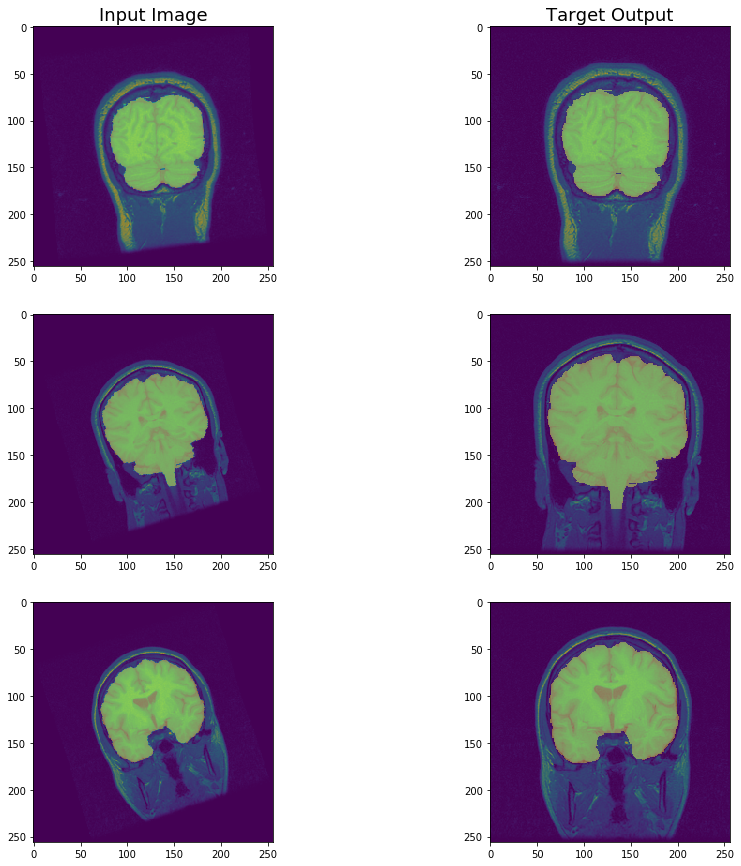

In [6]:
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,15))

im1 = data[20]
im2 = data[49]
im3 = data[789]

ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(im1[0].numpy().squeeze())
ax1[0].imshow(im2[0].numpy().squeeze())
ax2[0].imshow(im3[0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(im1[1].numpy().squeeze())
ax1[1].imshow(im2[1].numpy().squeeze())
ax2[1].imshow(im3[1].numpy().squeeze())

ax0[0].imshow(im1[2].numpy().squeeze(), alpha=0.4)
ax1[0].imshow(im2[2].numpy().squeeze(), alpha=0.4)
ax2[0].imshow(im3[2].numpy().squeeze(), alpha=0.4)

ax0[1].imshow(im1[3].numpy().squeeze(), alpha=0.4)
ax1[1].imshow(im2[3].numpy().squeeze(), alpha=0.4)
ax2[1].imshow(im3[3].numpy().squeeze(), alpha=0.4)

In [32]:
moving, fixed, moving_mask, fixed_mask = data[20]

In [33]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed.numpy().squeeze()))
elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving.numpy().squeeze()));

In [34]:
%%time
elastixImageFilter.Execute()

CPU times: user 2.23 s, sys: 1.02 s, total: 3.25 s
Wall time: 1.59 s


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f2f4d7ac0f0> >

In [35]:
output = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())

MSE: 0.00472668744623661


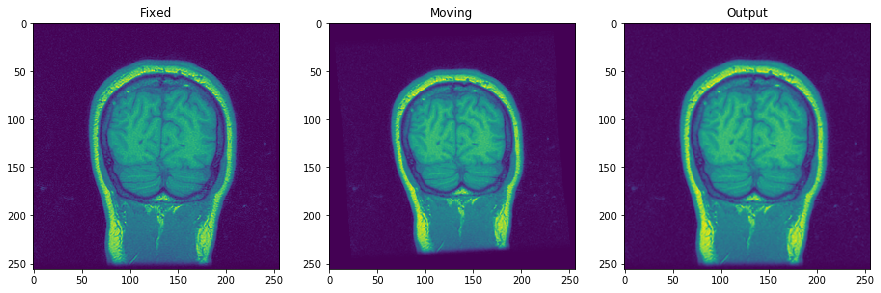

In [36]:
f, ax = plt.subplots(1,3,figsize=(15,20))
ax[0].set_title("Fixed")
ax[0].imshow(fixed.numpy().squeeze())
ax[1].set_title("Moving")
ax[1].imshow(moving.numpy().squeeze())
ax[2].set_title("Output")
ax[2].imshow(output)
print(f"MSE: {F.mse_loss(torch.Tensor(output), fixed)}")

In [70]:
bs = 16
outputs = []
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))

dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=4)        
moving, fixed, moving_mask, fixed_mask = next(iter(dl))

In [72]:
%%time

for i in range(bs):
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed[i].numpy().squeeze()))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving[i].numpy().squeeze()))
    elastixImageFilter.Execute()
    output = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    outputs.append(output)
    print(f"MSE: {F.mse_loss(torch.Tensor(output), fixed[i].squeeze())}")

MSE: 1.5434843301773071
MSE: 0.3380415439605713
MSE: 1.4012219905853271
MSE: 0.9565612077713013
MSE: 1.1533176898956299
MSE: 1.455674409866333
MSE: 0.4072001278400421
MSE: 0.008286918513476849
MSE: 0.005862490739673376
MSE: 1.7428791522979736
MSE: 2.1222760677337646
MSE: 1.107358694076538
MSE: 0.0047921291552484035
MSE: 1.0599325895309448
MSE: 1.0472272634506226
MSE: 1.4658293724060059
CPU times: user 37.3 s, sys: 8.47 s, total: 45.8 s
Wall time: 20.3 s


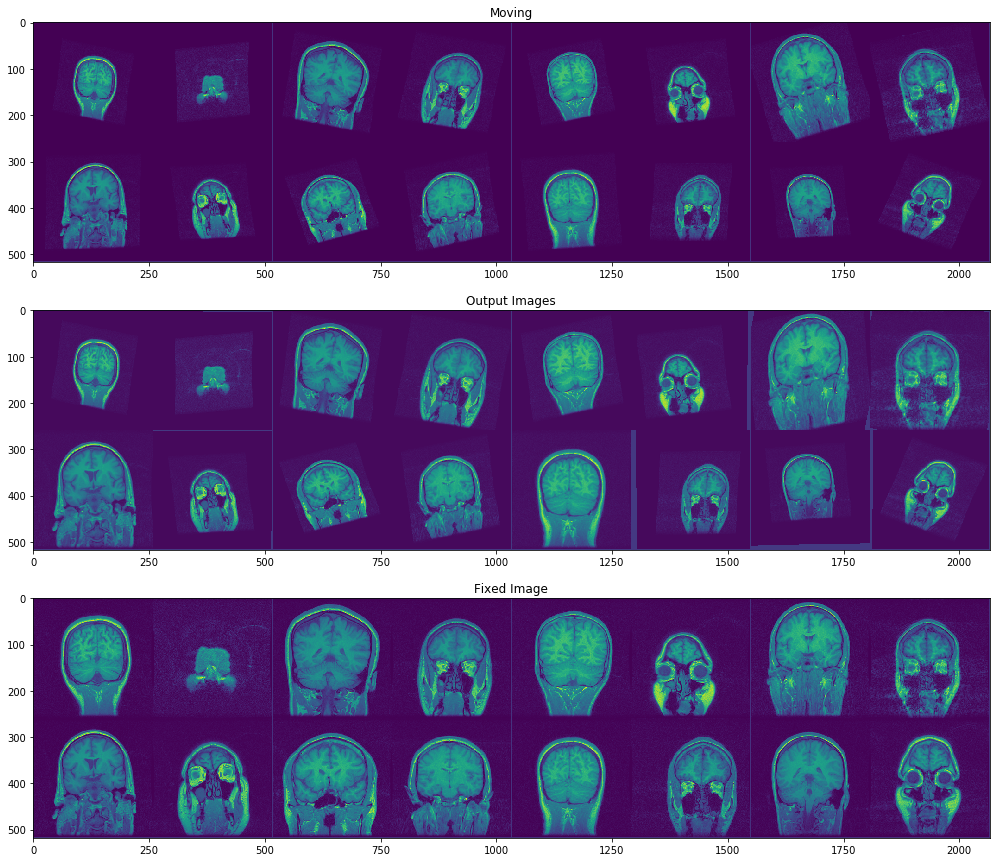

In [74]:
ims = np.stack(outputs)
f,ax = plt.subplots(3,1,figsize=(20,15))
ax[0].set_title("Moving")
ax[0].imshow(make_grid(moving).sum(0))
ax[1].set_title("Output Images")
ax[1].imshow(make_grid(torch.Tensor(ims)[:,None]).sum(0))
ax[2].set_title("Fixed Image")
ax[2].imshow(make_grid(fixed).sum(0))